### Dynamic Pricing, Elasticity & Inventory-Aware Revenue Optimization
Objective
- The objective of this project is to design a data-driven pricing strategy that maximizes realized revenue by accounting for customer price elasticity and operational inventory constraints.

- The analysis moves beyond theoretical demand modeling and evaluates whether pricing strategies are executable in real retail conditions.

### Business Problem
- Retailers frequently apply discounts or price increases to maximize revenue. However, aggressive pricing strategies can unintentionally cause stockouts or lost sales if inventory cannot support increased demand.

- This project answers a critical business question:
“Even if a price looks optimal on paper, can the business actually fulfill the demand it creates?”

### Dataset Summary

- Product pricing data

- Historical demand (units sold)

- Category information

- Simulated inventory availability

The dataset represents a realistic retail pricing environment suitable for elasticity analysis and scenario simulation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
df= pd.read_csv("ecommerce_pricing_featured_02.csv")
df.head()

,product_id,category,base_price,competitor_price,promotion_flag,season,customer_segment,day_of_week,channel,current_price,...,fulfilled_minus_10,fulfilled_plus_5,fulfilled_plus_10,feasible_revenue_baseline,feasible_revenue_minus_10,feasible_revenue_plus_5,feasible_revenue_plus_10,stock_minus_10,stock_plus_5,stock_plus_10
0,1102,Electronics,153.93,23.94,True,Fall,Regular,Tue,Web,111.99,...,602.000000,602.000000,602.000000,67417.980000,60676.182000,70788.879000,74159.778000,True,True,True
1,1435,Home,190.17,250.84,False,Spring,Premium,Sat,Mobile App,190.17,...,327.056638,137.952858,74.918265,38221.783673,55976.724816,27546.219808,15671.927082,False,False,False
2,1860,Electronics,166.57,257.71,False,Summer,Regular,Mon,Web,166.57,...,467.862734,302.226637,247.014604,59538.559139,70138.706071,52858.985435,45259.744907,False,False,False
3,1270,Electronics,215.97,238.38,False,Winter,Regular,Mon,Web,215.97,...,173.124550,-41.634578,-113.220954,6468.689904,33650.738241,-9441.410709,-26897.562284,False,False,False
4,1106,Fashion,102.55,255.81,True,Spring,Regular,Mon,Web,81.71,...,571.000000,571.000000,571.000000,46656.410000,41990.769000,48989.230500,51322.051000,True,True,True


### Section 1 — Price Elasticity Analysis
- To understand how sensitive demand is to price changes across product categories.

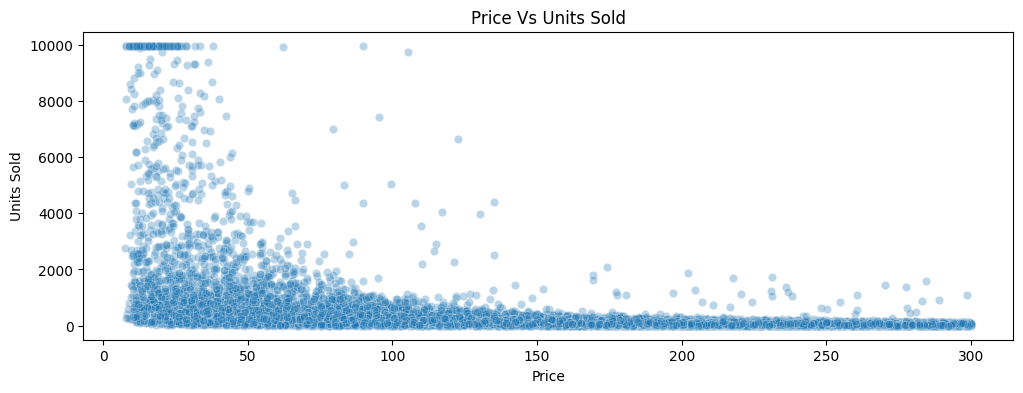

In [ ]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=df, x='current_price', y='units_sold', alpha=0.3)
plt.title("Price Vs Units Sold")
plt.xlabel("Price")
plt.ylabel("Units Sold")
plt.show()

#### Demand consistently decreases as price increases, confirming negative price elasticity across all categories. However, the strength of this relationship varies, indicating that pricing decisions must be category-specific.

### Elasticity Proxy Table


In [ ]:
elasticity_summary= (df.groupby('category').apply(lambda x: x['units_sold'].corr(x['current_price'])).reset_index(name='price_demand_correlation'))
elasticity_summary['elasticity_type'] = elasticity_summary['price_demand_correlation'].apply(lambda x: 'Elastic' if x < -0.5 else 'Inelastic')
elasticity_summary

/tmp/ipython-input-4033869042.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elasticity_summary= (df.groupby('category').apply(lambda x: x['units_sold'].corr(x['current_price'])).reset_index(name='price_demand_correlation'))


,category,price_demand_correlation,elasticity_type
0,Electronics,-0.408791,Inelastic
1,Fashion,-0.401486,Inelastic
2,Grocery,-0.393972,Inelastic
3,Home,-0.412270,Inelastic


#### Interpretation

#### Elasticity Interpretation

- Highly Elastic: Small price changes cause large demand changes

- Moderately Elastic: Demand responds but less aggressively

- Electronics, Fashion, and Home show high elasticity, while Grocery is moderately elastic.

### Section 2 — Demand Modeling & Revenue Curves
#### Model Explanation

Why Linear Regression?
- A linear demand model was selected for transparency and interpretability. While more complex models exist, linear regression clearly demonstrates economic relationships and supports business decision-making.

In [ ]:
#Target Variable
x=df[['current_price']]
y=df['units_sold']
model= LinearRegression()
model.fit(x,y)
# Coefficients
price_coef= model.coef_[0]
intercept= model.intercept_
price_coef, intercept

(np.float64(-6.6292888835148265), np.float64(1461.6793185883666))

#### Model Output
Coefficient Interpretation
- The negative price coefficient confirms that increasing prices reduces demand.
The intercept represents expected demand when price approaches zero, serving as a baseline reference point.

### Simulated Demand Curve

In [ ]:
price_range=np.linspace(df['current_price'].min(), df['current_price'].max(), 50)
price_df = pd.DataFrame({'current_price': price_range})

simulated_demand = model.predict(price_df)
simulated_revenue = price_range * simulated_demand

simulation_df = pd.DataFrame({'Price': price_range,'Predicted_Demand': simulated_demand,'Revenue': simulated_revenue})

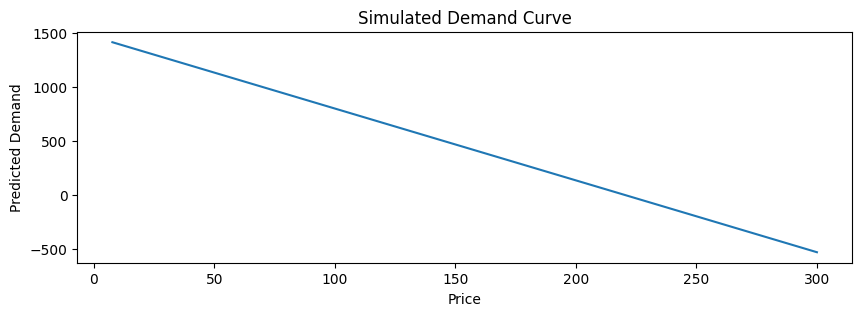

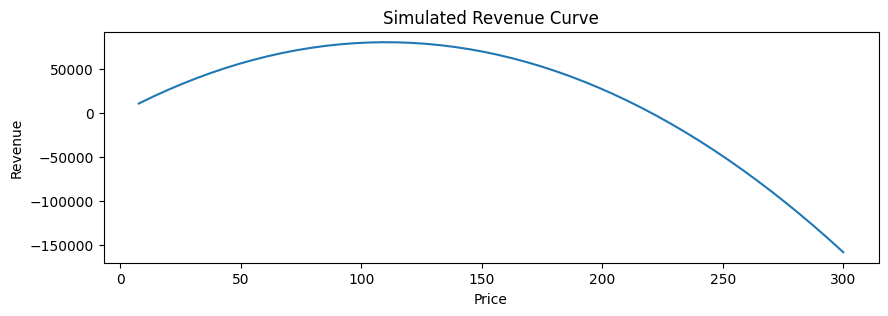

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(simulation_df['Price'], simulation_df['Predicted_Demand'])
plt.xlabel("Price")
plt.ylabel("Predicted Demand")
plt.title("Simulated Demand Curve")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(simulation_df['Price'], simulation_df['Revenue'])
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.title("Simulated Revenue Curve")
plt.show()

#### Interpretation

#### Demand Curve Insight
- Demand declines steadily as price increases, forming a downward-sloping demand curve consistent with economic theory.
#### Revenue Curve Insight
- Revenue increases initially as prices rise, but beyond an optimal point, demand loss outweighs price gains, reducing total revenue.

#### Optimal Price Extraction

Optimal Price Logic
- The optimal price is identified as the price point that maximizes predicted revenue under the demand curve.

In [ ]:
optimal_prices = {}

for cat in df['category'].unique():
    temp = df[df['category'] == cat]

    X_cat = temp[['current_price']]
    y_cat = temp['units_sold']

    model_cat = LinearRegression()
    model_cat.fit(X_cat, y_cat)

    price_range = np.linspace(temp['current_price'].min(),temp['current_price'].max(),50)

    price_df = pd.DataFrame({'current_price': price_range})
    demand_pred = model_cat.predict(price_df)
    revenue = price_range * demand_pred

    optimal_prices[cat] = price_range[np.argmax(revenue)]
optimal_prices

{'Electronics': np.float64(115.59918367346941),
 'Home': np.float64(109.22428571428571),
 'Fashion': np.float64(109.83775510204083),
 'Grocery': np.float64(109.08857142857141)}

#### Section 3 — Pricing Scenario Simulation
Scenarios

- Simulated Pricing Scenarios

Baseline price

- −10% discount

- +5% price increase

- +10% price increase

In [ ]:
scenario_summary= pd.DataFrame({
    'Scenario':['Baseline','-10% Price', '+5% Price','+10% Price'],
    'Total_Revenue':[df['revenue_baseline'].sum(),
                     df['revenue_minus_10'].sum(),
                     df['revenue_plus_5'].sum(),
                     df['revenue_plus_10'].sum()]})
scenario_summary.sort_values(by='Total_Revenue',ascending=False)

,Scenario,Total_Revenue
1,-10% Price,4.890323e+08
0,Baseline,3.209570e+08
2,+5% Price,2.202385e+08
3,+10% Price,1.083993e+08


#### Interpretation

Key Observation
- A −10% discount generates the highest theoretical revenue due to increased demand, while aggressive price increases significantly reduce revenue.

#### Section 4 — Inventory-Aware Feasibility
Critical Business Rule

Core Retail Rule
- You can only sell what you have.

In [ ]:
def fulfilled_demand(predicted, inventory):
    return np.minimum(predicted, inventory)

- If predicted demand exceeds available inventory, sales are capped at inventory levels. Any excess demand results in lost revenue.
### Fulfilled Demand & Feasible Revenue
- Feasible Revenue represents revenue the business can actually realize after accounting for inventory limits, not theoretical demand.
### Stockout Risk Calculation
Stockout Risk Definition

- Low: < 10% of items stock out

- Medium: 10–30%

- High: > 30%

These thresholds are standard in retail risk management.

### Executive Scenario Table

In [ ]:
stockout_rate_minus_10 = df['stock_minus_10'].mean()
stockout_rate_plus_5 = df['stock_plus_5'].mean()
stockout_rate_plus_10 = df['stock_plus_10'].mean()
def risk_label(rate):
  if rate < 0.10:
    return "Low"
  elif rate < 0.30:
    return "Medium"
  else:
    return "High"

scenario_summary= pd.DataFrame({'Scenario': ['Baseline', '-10% Price', '5% Price', '10% Price'],
                                'Theoretical_Revenue': [df['revenue_baseline'].sum(), df['revenue_minus_10'].sum(), df['revenue_plus_5'].sum(), df['revenue_plus_10'].sum()],
                                'Feasible_Revenue': [df['feasible_revenue_baseline'].sum(), df['feasible_revenue_minus_10'].sum(), df['feasible_revenue_plus_5'].sum(), df['feasible_revenue_plus_10'].sum()],
                                'Stockout_Risk': ['Low', risk_label(stockout_rate_minus_10), risk_label(stockout_rate_plus_5), risk_label(stockout_rate_plus_10)]})
scenario_summary

,Scenario,Theoretical_Revenue,Feasible_Revenue,Stockout_Risk
0,Baseline,3.209570e+08,2.733505e+08,Low
1,-10% Price,4.890323e+08,4.355521e+08,High
2,5% Price,2.202385e+08,1.751865e+08,Medium
3,10% Price,1.083993e+08,6.568919e+07,Medium


In [ ]:
scenario_summary.to_csv("scenario_summary.csv", index=False)

#### Interpretation

Key Insight
- Although a −10% discount maximizes theoretical revenue, high stockout risk significantly reduces realizable revenue.

- Pricing strategies must therefore be evaluated on feasibility, not demand alone.

#### Section 5 — Elasticity & Risk Segmentation

In [ ]:
elasticity_summary= (df.groupby('category').apply(lambda x: x['units_sold'].corr(x['current_price'])).reset_index(name='price_elasticity_proxy'))
elasticity_summary
def elasticity_band(value):
  if value <= -0.40:
    return "Highly Elastic"
  elif value <= -0.25:
    return "Moderately Elastic"
  else:
    return "Inelastic"
elasticity_summary['elasticity_band']= elasticity_summary['price_elasticity_proxy'].apply(elasticity_band)
elasticity_summary
stockout_summary= df.groupby("category").agg({'stock_minus_10': 'mean',
                                              'stock_plus_5': 'mean',
                                              'stock_plus_10': 'mean'}).reset_index()
elasticity_risk_table= elasticity_summary.merge(stockout_summary, on='category', how='left')
elasticity_risk_table
def risk_label(rate):
  if rate < 0.10:
    return "Low"
  elif rate < 0.30:
    return "Medium"
  else:
    return "High"
for col in ['stock_minus_10', "stock_plus_5", "stock_plus_10"]: elasticity_risk_table[col+ '_risk']= elasticity_risk_table[col].apply(risk_label)
elasticity_risk_table

/tmp/ipython-input-184559928.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elasticity_summary= (df.groupby('category').apply(lambda x: x['units_sold'].corr(x['current_price'])).reset_index(name='price_elasticity_proxy'))


,category,price_elasticity_proxy,elasticity_band,stock_minus_10,stock_plus_5,stock_plus_10,stock_minus_10_risk,stock_plus_5_risk,stock_plus_10_risk
0,Electronics,-0.408791,Highly Elastic,0.339728,0.287060,0.271015,High,Medium,Medium
1,Fashion,-0.401486,Highly Elastic,0.328217,0.274351,0.258722,High,Medium,Medium
2,Grocery,-0.393972,Moderately Elastic,0.354300,0.296106,0.281985,High,Medium,Medium
3,Home,-0.412270,Highly Elastic,0.343981,0.287492,0.273033,High,Medium,Medium


##### Strategic Insight
- All categories show that the revenue-maximizing scenario (−10% discount) also carries High stockout risk, making it operationally dangerous without inventory buildup.

#### Final Executive Summary
- Revenue-maximizing prices may be operationally infeasible

- Discounts amplify demand faster than inventory can respond

- Inventory constraints materially reduce achievable revenue

#### Business Recommendation
- Pricing decisions should optimize realized revenue, not theoretical demand.
- Moderate price adjustments combined with inventory planning outperform aggressive discounting.